# 1 引言

<b>研究目的：</b>    
本文参考方正证券《行业轮动的黄金律：日内动量与隔夜反转》，对研报里面的结果进行了分析，并对比了传统动量因子策略和将传统动量因子拆分后日内涨跌幅因子和隔夜涨跌幅因子的效果。

<b>研究内容：</b>    
不同的交易者群体，会有不同的行为模式。 在交易日内的不同时段，交易者的成分可能存在系统性差异， 因而会导向不同的市场行为
特征，最终形成各式各样的日内模式（intraday patterns）。按照这个思路，为了研究动量效应的日内精细规律，本文将行业指数的每
日收益率拆解为日内收益率（今收/今开-1） 和隔夜收益率（今开/昨收-1）。

1）将过去 15 个交易日的日内收益率加总，命名为日内涨跌幅因子 M0；将过去 15 个交易日的隔夜收益率加总，称为隔夜涨跌幅因子M1。    
2）将这两个效应结合在一起， 构建新的行业轮动模型。 在具体操作上,我们将 N 个行业指数按照 M0 因子值从低到高分别打 1 分至 N 分,按照 M1 因子值从高到低分别打1分至N分，将两项打分相加,得到每个行业的总得分，此因子命名为黄金律因子M_gold。


3）行业轮动的回测框架如下：   
   测试时段： 2006 年 1 月-2017 年 11 月；    
   样本空间： 申万一级行业指数（共 28 个）； 
   调仓方式： 在每个月初，将行业指数按总得分排序，划分为五组，分别持有至月末；得分最高的组合为多头组合，得分最低的组合 
              为空头组合


<b>本文所用因子构建细节：</b>  
根据研究内容，我们列出本文所用的四个因子构建细则：

1）传统动量因子：前十五天涨跌幅

2）日内涨跌幅因子M0：前十五日内收益率加总，其中日内收益率为今收/今开-1

3）隔夜涨跌幅因子M1:前十五日隔夜收益率加总，其中隔夜收益率为今开/昨收-1

4）黄金律因子M_gold：将日内涨跌幅因子和隔夜涨跌幅因子根据打分法等权加总构成黄金律因子，其中日内涨跌幅因子由于动量效应采取从低到高分别打1-N分，而隔夜涨跌幅因子由于反转效应由高到底分别打1-N分。

<b>研究结论：</b>   
1）本文将传统的动量因子（即前十五日涨跌幅）进行分拆，对交易者的行为模式进行进一步细化，可以发现交易者存在不同的日内交易模式，这为构建新的因子提供思路。

2）可以发现行业指数存在“日内动量”与“隔夜反转”的黄金律：即日内涨跌幅因子 M0（前15天的日内收益率加总） 呈现显著的动量效应，因子越大的组合能够带来更大的收益， 而隔夜涨跌幅因子 M1 （前十五日隔夜收益率加总）则呈现反转效应，因子值越小的组合超额收益更加明显。 

3）将两个因子按照打分法等权结合得到的黄金律因子构建行业轮动组合，可以发现顶部组合年化收益约有7%的提升，同时最大回撤情况也有明显改善。 对比传统的动量因子夏普比率0.68，黄金律因子的夏普比率可达0.87。



<b>研究耗时：</b>   
1）数据准备部分：大约需要20min，数据采集部分需要注意，目前平台暂无提供直接的API获取行业数据，以下的内容都是调用了聚源数据库进行的操作，具体数据源可以参考这个链接
      https://www.joinquant.com/help/data/data?name=jy#nodeId=17    
2）策略构建部分：大约需要30min，主要对模型进行调整。

In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/17114
# 标题：行业轮动的黄金律：日内动量与隔夜反转

import pandas as pd
import numpy as np
from  datetime import datetime,timedelta
import pickle
from matplotlib import pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns
from jqdata import jy

sns.set_style("whitegrid", {"axes.facecolor": ".99"})
sns.set_context("notebook",font_scale=1.2, rc={"lines.linewidth": 1.5})
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family']='sans-serif'

# 2.导入数据

目前平台暂无提供直接的API获取行业数据，以下的内容都是调用了聚源数据库进行的操作，具体数据源可以参考这个链接
https://www.joinquant.com/help/data/data?name=jy#nodeId=17， 我们利用get_SW_index这个函数提取每一个申万二级行业指数的数据，利用index_list确定提取指标，如收盘价‘ClosePrice’等，其中codelist为申万二级指数的代码汇总，我们可以利用get_SW_index函数提取出交易数据

设置开始回测的开始时间和结束时间，将index_list设置为收盘价与开盘价，利用get_SW_index分别提取出所有申万二级指数的收盘价和开盘价

In [2]:
def get_SW_index(SW_index,start_date,end_date,index_list = ['ClosePrice']):
    jydf = jy.run_query(query(jy.SecuMain).filter(jy.SecuMain.SecuCode==str(SW_index)))
    link=jydf[jydf.SecuCode==str(SW_index)]
    rows=jydf[jydf.SecuCode==str(SW_index)].index.tolist()
    result=link['InnerCode'][rows]
    df = jy.run_query(query(jy.QT_SYWGIndexQuote).filter(jy.QT_SYWGIndexQuote.InnerCode==str(result[0]),\
                                                   jy.QT_SYWGIndexQuote.TradingDay>=start_date,\
                                                         jy.QT_SYWGIndexQuote.TradingDay<=end_date
                                                        ))
    df.index = df['TradingDay']
    df = df[index_list]
    df.columns = [SW_index] 
    return df

codelist = [801010,801020,801030,801040,801050,801080,801110,801120,801130,801140,801150,801160,801170,801180,801200,801210,801230,801710,801720,801730,801740,801750,801760,801770,801780,801790,801880,801890]

start_date=datetime(2005,12,1)
end_date=datetime(2017,12,31)

price_close = pd.DataFrame()
for i in range(0,len(codelist)):
    df = get_SW_index(SW_index = codelist[i],start_date=start_date,end_date=end_date,index_list = ['ClosePrice'])
    price_close = pd.concat([price_close,df],axis=1)

price_open = pd.DataFrame()
for i in range(0,len(codelist)):
    df = get_SW_index(SW_index = codelist[i],start_date=start_date,end_date=end_date,index_list = ['OpenPrice'])
    price_open = pd.concat([price_open,df],axis=1)



/opt/conda/lib/python3.6/site-packages/sqlalchemy/dialects/mysql/base.py:1942: SAWarning: MariaDB (10, 2, 6) before 10.2.9 has known issues regarding CHECK constraints, which impact handling of NULL values with SQLAlchemy's boolean datatype (MDEV-13596). An additional issue prevents proper migrations of columns with CHECK constraints (MDEV-11114).  Please upgrade to MariaDB 10.2.9 or greater, or use the MariaDB 10.1 series, to avoid these issues.
  "series, to avoid these issues." % (mdb_version, ))


# 3. 黄金律：日内动量+隔夜反转

不同的交易者群体，会有不同的行为模式。在交易日内的不同时段，交易者的成分可能存在系统性差异， 因而会导向不同的市场行为
特征，最终形成各式各样的日内模式（intraday patterns）。按照这个思路，为了研究动量效应的日内精细规律， 报告将行业指数的每日收益率拆解为日内收益率（今收/今开-1） 和隔夜收益率（今开/昨收-1）。
在本篇报告中，我们将过去 15 个交易日的日内收益率加总，命名为日内涨跌幅因子 M0；将过去 15 个交易日的隔夜收益率加总，称
为隔夜涨跌幅因子 M1。

首先我们设置回测的一些参数，即开始回测时间和年份

In [3]:
start='2006'
end='2017'
u1=[23,17,11,5,0]
u2=[27,22,16,10,4]

下面的def_alpha函数是我们根据之前说的因子计算逻辑计算出四个因子，即M-传统的动量因子，M0-日内涨跌幅因子，M1-隔夜涨跌幅因子，M_gold-M1和M2的复合因子。 

同时后续会利用report这个函数对比这四个因子的选股效果，report函数计算得到了年化收益率，最大会回撤等指标，可以对策略收益进行量化衡量，我们同时给出如计算得到的传统动量因子，如下所示:

In [4]:
def get_alpha(price_open,price_close,start,end):
    r1=(price_close/price_open)-1
    r2=pd.DataFrame((np.array(price_open.iloc[1:])/np.array(price_close[0:-1]))-1,columns=r1.columns,index=r1.index[1:] )
    M=price_close.pct_change(15).dropna()[start:end]
    M0=r1.rolling(15).sum().dropna()[start:end]
    M1=r2.rolling(15).sum().dropna()[start:end]
    M0.index=pd.to_datetime(M0.index.astype(str))
    M1.index=pd.to_datetime(M1.index.astype(str))
    rank0=M0.rank(axis=1)
    rank1=M1.rank(axis=1, ascending=False)
    M_gold=rank0+rank1
    return M,M0,M1,M_gold   

M,M0,M1,M_gold= get_alpha(price_open,price_close,start,end)

def report(ret,freqcy=1):
    ret.fillna(0,inplace=True)
    net = (1+ret).cumprod()
    yld_rate = (net.iloc[-1]/net.iloc[0]) ** (242/freqcy/len(net)) - 1 
    sigma = np.std(ret) * np.sqrt(242/freqcy) # 年化波动率
    sharpe = yld_rate / sigma # 夏普比 sharpe ratio
    drawdown = net/net.cummax() - 1 #回撤
    maxdrawdown = max(-drawdown[0])
    summary_table = pd.DataFrame(index=[0])
    summary_table["年化收益率"] = str(round(yld_rate[0]*100,2))+'%'
    summary_table["年化波动率"] = str(round(sigma[0]*100,2))+'%'
    summary_table["收益波动比"] = str(round(sharpe[0],2))
    summary_table["最大回撤"] = str(round(maxdrawdown*100,2))+'%'
    return summary_table

M.head()

,801010,801020,801030,801040,801050,801080,801110,801120,801130,801140,801150,801160,801170,801180,801200,801210,801230,801710,801720,801730,801740,801750,801760,801770,801780,801790,801880,801890
TradingDay,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-04,0.059206,0.071121,0.064665,0.040818,0.061761,0.068098,0.051627,0.064617,0.040160,0.042373,0.045036,0.030195,0.047262,0.078032,0.046250,0.037186,0.040569,0.049567,0.072541,0.067919,0.068134,0.072194,0.044409,0.065763,0.082399,0.040440,0.053336,0.074876
2006-01-05,0.065888,0.072000,0.071032,0.062522,0.080737,0.084594,0.072681,0.081302,0.047000,0.063897,0.060388,0.044951,0.086266,0.099537,0.054986,0.046625,0.060835,0.061682,0.079535,0.078091,0.083744,0.079483,0.082533,0.075935,0.102675,0.047771,0.069277,0.089713
2006-01-06,0.057714,0.074915,0.078065,0.064172,0.080513,0.078629,0.072503,0.081691,0.049449,0.063722,0.057361,0.048062,0.094142,0.085025,0.048672,0.049074,0.061975,0.053499,0.075332,0.078279,0.061532,0.096564,0.066007,0.073838,0.096392,0.045611,0.068667,0.085898
2006-01-09,0.080049,0.105918,0.089106,0.066864,0.118700,0.098247,0.089878,0.087794,0.069585,0.080355,0.073728,0.056044,0.094967,0.094025,0.060359,0.048933,0.091603,0.074534,0.090231,0.101082,0.101212,0.128468,0.085612,0.072089,0.093773,0.098419,0.072518,0.115765
2006-01-10,0.078413,0.110111,0.094758,0.054472,0.129904,0.090364,0.074618,0.074990,0.061264,0.078076,0.066441,0.048380,0.079590,0.091510,0.058608,0.032418,0.082687,0.075226,0.084798,0.118517,0.088833,0.123113,0.068571,0.061779,0.112946,0.088222,0.066917,0.102997


在这里，利用resample这个函数，写出get_month这个函数从而根据因子索引得到月末时间点和月初时间点，输出月末时间点如下所示。

同时在本文中我们利用打分法进行选股，get_alpharank就是用于做因子排序，输入因子和日期，我们可以将那一天的排序值输出

In [5]:
def get_month(alpha):
  ym_begin=pd.Series(alpha.index,index=M0.index).resample('M').first().dropna()
  ym_end=pd.Series(M0.index,index=M0.index).resample('M').last().dropna()
  return ym_begin,ym_end
ym_begin,ym_end=get_month(M)

ym_end.head()

def get_alpharank(alpha,date):
    alpha0=alpha.loc[date]
    t=pd.DataFrame(np.argsort(np.array(alpha0),axis=1),index=alpha0.index)
    return t  

下面可以对调仓时候的净值进行计算，如group1，a1就是传统动量因子的分组一的结果。下图展示了传统动量因子（以 15 日涨跌幅替代） 在行业轮动上的应用效果，测试对象为申万二级行业指数。可以看出五分组净值曲线之间的区分度不太理想。 

<Figure size 432x288 with 0 Axes>

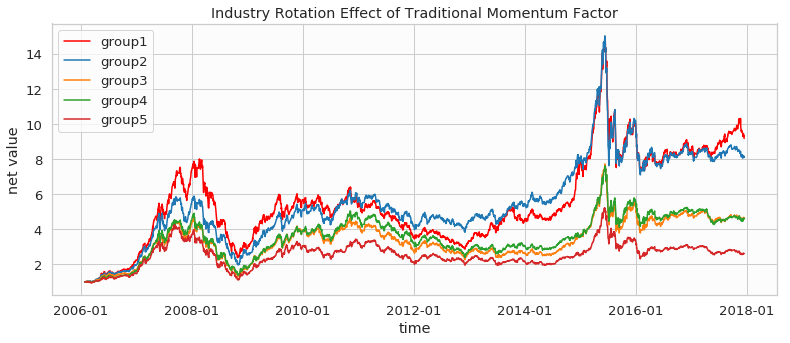

In [6]:
def get_group(g,h,u1,u2,price,rank,date):   
    group=pd.DataFrame(np.zeros((len(price[date[0]:]),h)),index=price[date[0]:].index)
    a=pd.DataFrame(np.zeros((len(price[date[0]:]),1)),index=price[date[0]:].index)
    i=0
    s=1    
    while i<len(date)-1:
        df=price.iloc[:,rank.loc[date[i],u1[g-1]:u2[g-1]]]
        df=df.loc[date[i]:date[i+1]+timedelta(-1)]
        df=pd.DataFrame(df.values,index=price.loc[date[i]:date[i+1]+timedelta(-1)].index)
        a1=(((s/h)/df.iloc[0,])*df).sum(axis=1)
        s=a1[-1]
        group.loc[date[i]:date[i+1]+timedelta(-1)]=df
        a.loc[date[i]:date[i+1]+timedelta(-1)]=pd.DataFrame(a1)
        i=i+1 
    group=group.iloc[:-10]
    a=a.iloc[:-10]
    return group,a    

t=get_alpharank(M,ym_end)
group1,a1=get_group(1,5,u1,u2,price_close,t,ym_end)
group2,a2=get_group(2,6,u1,u2,price_close,t,ym_end)
group3,a3=get_group(3,6,u1,u2,price_close,t,ym_end)
group4,a4=get_group(4,6,u1,u2,price_close,t,ym_end)
group5,a5=get_group(5,5,u1,u2,price_close,t,ym_end)

plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
ax1.plot(a1,'r',label=u'group1')
ax1.plot(a2,label=u'group2')
ax1.plot(a3,label=u'group3')
ax1.plot(a4,label=u'group4')
ax1.plot(a5,label=u'group5')
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('net value') 
plt.title('Industry Rotation Effect of Traditional Momentum Factor') 
plt.show()

我们给出了多空净值（第 1 组-第 5 组）的走势，结论是上升趋势不够稳定且回撤较大。 也就是说，直接基于指数前期
涨跌幅构建的动量轮动策略， 效果是难以令人满意的。

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

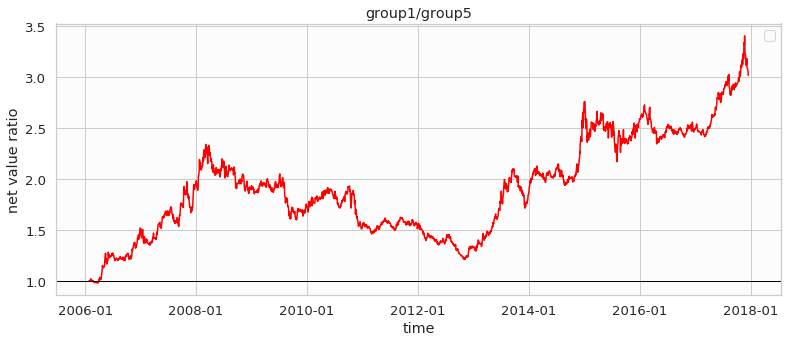

In [7]:
ret_long = a1.pct_change() - a5.pct_change()
(ret_long.fillna(0)+1).cumprod()
d = (ret_long.fillna(0)+1).cumprod()
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
ax1.plot(d,'r')
ax1.axhline(1.0, linestyle='-', color='black', lw=1)
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('net value ratio') 
plt.title('group1/group5') 
plt.show()


In [8]:
table1 = pd.DataFrame(report(a1.pct_change(),freqcy=1))
table1.index = ['组合一']
table2 = pd.DataFrame(report(a2.pct_change(),freqcy=1))
table2.index = ['组合二']
table3 = pd.DataFrame(report(a3.pct_change(),freqcy=1))
table3.index = ['组合三']
table4 = pd.DataFrame(report(a4.pct_change(),freqcy=1))
table4.index = ['组合四']
table5 = pd.DataFrame(report(a5.pct_change(),freqcy=1))
table5.index = ['组合五']
pd.concat([table1,table2,table3,table4,table5],axis=0)

,年化收益率,年化波动率,收益波动比,最大回撤
组合一,20.37%,30.15%,0.68,70.09%
组合二,19.12%,29.22%,0.65,66.52%
组合三,13.7%,29.27%,0.47,72.02%
组合四,13.62%,29.04%,0.47,71.92%
组合五,8.37%,29.69%,0.28,73.43%


为了考察因子对行业指数未来收益的预测能力， 我们分别按照 M0、 M1 由高到低将行业指数排序分成 5 组， 在每个自然月的月末进行调仓。 下图 给出了两种因子下各组合的年化收益率。我们的结论是：日内涨跌幅因子 M0 呈现显著的动量效应，而隔夜涨跌幅因子 M1 则呈现反转效应。

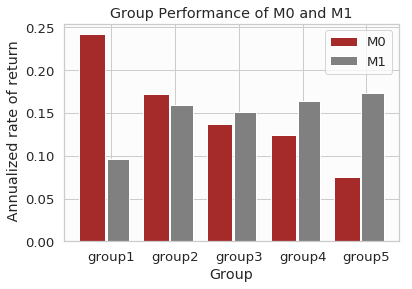

In [9]:
t0=get_alpharank(M0,ym_end)

group01,a01=get_group(1,5,u1,u2,price_close,t0,ym_end)
group02,a02=get_group(2,6,u1,u2,price_close,t0,ym_end)
group03,a03=get_group(3,6,u1,u2,price_close,t0,ym_end)
group04,a04=get_group(4,6,u1,u2,price_close,t0,ym_end)
group05,a05=get_group(5,5,u1,u2,price_close,t0,ym_end)

z=pd.DataFrame(np.zeros((5,1)),index=list(['分组一','分组二','分组三','分组四','分组五']))
z.iloc[0]=(a01.iloc[-1])**(1/(len(group01)/240))-1
z.iloc[1]=(a02.iloc[-1])**(1/(len(group01)/240))-1
z.iloc[2]=(a03.iloc[-1])**(1/(len(group01)/240))-1
z.iloc[3]=(a04.iloc[-1])**(1/(len(group01)/240))-1
z.iloc[4]=(a05.iloc[-1])**(1/(len(group01)/240))-1

t1=get_alpharank(M1,ym_end)

group11,a11=get_group(1,5,u1,u2,price_close,t1,ym_end)
group12,a12=get_group(2,6,u1,u2,price_close,t1,ym_end)
group13,a13=get_group(3,6,u1,u2,price_close,t1,ym_end)
group14,a14=get_group(4,6,u1,u2,price_close,t1,ym_end)
group15,a15=get_group(5,5,u1,u2,price_close,t1,ym_end)

w=pd.DataFrame(np.zeros((5,1)),index=list(['分组一','分组二','分组三','分组四','分组五']))
w.iloc[0]=(a11.iloc[-1])**(1/(len(group01)/240))-1
w.iloc[1]=(a12.iloc[-1])**(1/(len(group01)/240))-1
w.iloc[2]=(a13.iloc[-1])**(1/(len(group01)/240))-1
w.iloc[3]=(a14.iloc[-1])**(1/(len(group01)/240))-1
w.iloc[4]=(a15.iloc[-1])**(1/(len(group01)/240))-1

plt.bar(np.arange(5),np.array(z[0]),0.4,color='brown',label='M0')
plt.bar(np.arange(5)+0.4,np.array(w[0]),0.35,color='gray',label='M1')
plt.xlabel('Group')
plt.ylabel(' Annualized rate of return') 
plt.title('Group Performance of M0 and M1') 
plt.xticks(np.arange(5)+0.3, ('group1', 'group2', 'group3', 'group4', 'group5')) 
plt.legend()
plt.show()


# 4.基于黄金律的行业轮动模型

按照前文所述，行业指数存在“日内动量”与“隔夜反转”的黄金律，下面我们尝试将这两个效应结合在一起， 构建新的行业轮动模
型。在具体操作上，我们将 N 个行业指数按照 M0 因子值从低到高分别打 1 分至 N分，按照 M1 因子值从高到低分别打 1 分至 N 分， 将两项打分相加，得到每个行业的总得分。

行业轮动的回测框架如下:      
1) 测试时段： 2006 年 1 月-2017 年 11 月;   
2) 样本空间： 申万一级行业指数（共 28 个）；    
3) 调仓方式： 在每个月初，将行业指数按总得分排序，划分为五组， 分别持有至月末；    
4) 得分最高的组合为多头组合，得分最低的组合为空头组合。    

下图为各分组的净值走势曲线

<Figure size 432x288 with 0 Axes>

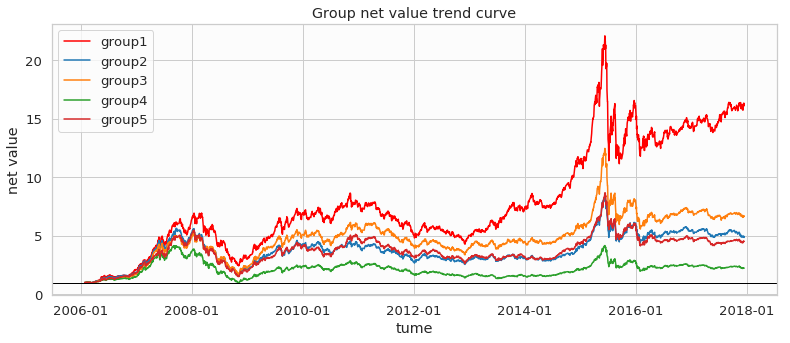

In [10]:
t_gold=get_alpharank(M_gold,ym_end)
group_gold1,a_gold1=get_group(1,5,u1,u2,price_close,t_gold,ym_end)
group_gold2,a_gold2=get_group(2,6,u1,u2,price_close,t_gold,ym_end)
group_gold3,a_gold3=get_group(3,6,u1,u2,price_close,t_gold,ym_end)
group_gold4,a_gold4=get_group(4,6,u1,u2,price_close,t_gold,ym_end)
group_gold5,a_gold5=get_group(5,5,u1,u2,price_close,t_gold,ym_end)

plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
ax1.plot(a_gold1,'r',label=u'group1')
ax1.plot(a_gold2,label=u'group2')
ax1.plot(a_gold3,label=u'group3')
ax1.plot(a_gold4,label=u'group4')
ax1.plot(a_gold5,label=u'group5')
ax1.axhline(1.0, linestyle='-', color='black', lw=1)
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('tume')
plt.ylabel('net value') 
plt.title('Group net value trend curve') 
plt.show()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

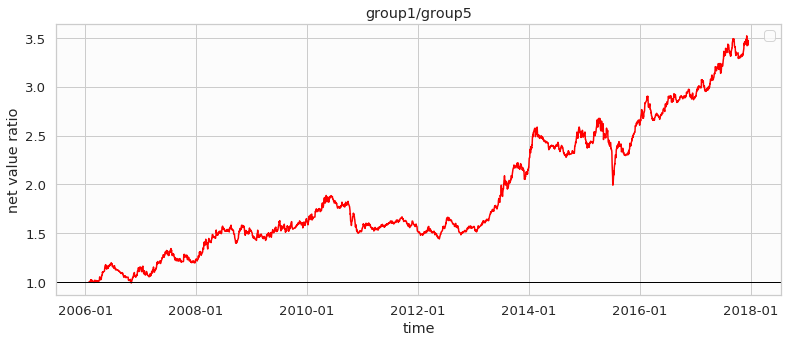

In [11]:
v=pd.DataFrame(np.zeros((5,1)),index=list(['分组一','分组二','分组三','分组四','分组五']))
v.iloc[0]=(a_gold1.iloc[-1])**(1/(len(group01)/240))-1
v.iloc[1]=(a_gold2.iloc[-1])**(1/(len(group01)/240))-1
v.iloc[2]=(a_gold3.iloc[-1])**(1/(len(group01)/240))-1
v.iloc[3]=(a_gold4.iloc[-1])**(1/(len(group01)/240))-1

ret_long = a_gold1.pct_change() - a_gold5.pct_change()
(ret_long.fillna(0)+1).cumprod()
d = (ret_long.fillna(0)+1).cumprod()
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
ax1.plot(d,'r')
ax1.axhline(1.0, linestyle='-', color='black', lw=1)
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('net value ratio') 
plt.title('group1/group5') 
plt.show()


In [12]:
table1 = pd.DataFrame(report(a_gold1.pct_change(),freqcy=1))
table1.index = ['组合一']
table2 = pd.DataFrame(report(a_gold2.pct_change(),freqcy=1))
table2.index = ['组合二']
table3 = pd.DataFrame(report(a_gold3.pct_change(),freqcy=1))
table3.index = ['组合三']
table4 = pd.DataFrame(report(a_gold4.pct_change(),freqcy=1))
table4.index = ['组合四']
table5 = pd.DataFrame(report(a_gold5.pct_change(),freqcy=1))
table5.index = ['组合五']
pd.concat([table1,table2,table3,table4,table5],axis=0)

pd.concat([table1,table2,table3,table4,table5],axis=0)

,年化收益率,年化波动率,收益波动比,最大回撤
组合一,26.17%,30.22%,0.87,64.93%
组合二,14.13%,29.44%,0.48,70.88%
组合三,17.17%,29.18%,0.59,67.19%
组合四,6.93%,28.85%,0.24,76.46%
组合五,13.45%,28.59%,0.47,72.48%


# 5 结论

<b>研究结论：</b>    
本篇报告重点讨论动量因子的行业轮动应用。 基于“日内不同时段交易者行为模式存在差异”的考虑，我们将传统动量因子进行拆分，首次提出了“日内动量+隔夜反转”的行业轮动黄金律。  

通过对比传统动量因子和改进后的动量因子，我们发现明显的有一些策略业绩的提升：
从顶部组合来看，传统动量因子的年化收益率只有20.37%，但经过改进后的因子有26.17%。同时从收益波动来看，经过改进后的因子的最大回撤也从70%降低为64%左右。即不管是盈利能力还是盈利稳定性，改进后的因子都超过了传统的动量因子。

<b>未来展望：</b>    
研究结果为我们提供了一定的思考方向，即对一些传统因子的改进，可以提升其效果。同时我们在这里将传统动量因子的参数默认为15天，这也是一个值得探讨的影响要求，参数可能会对因子效果产生一定的影响。同时本篇报告并没有将换手因素加入，即没有考虑交易费用所带来的影响。这都是之后值得研究的问题。